<a href="https://colab.research.google.com/github/Gautam3767/Internship-Week-3/blob/main/image_augementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gautamgirdhar","key":"7fdfdf995aa4844836e5a9736772c03d"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:05<00:00, 165MB/s]
100% 812M/812M [00:05<00:00, 163MB/s]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
import zipfile
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats')

with zipfile.ZipFile('dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats/train')


In [3]:
import os

# List directories to ensure correct paths
!ls /content/dogs-vs-cats/
!ls /content/dogs-vs-cats/train/

sampleSubmission.csv  test1.zip  train	train.zip
train


In [4]:
def load_and_display_images(folder_path, num_images=10):
  images = os.listdir(folder_path)[:num_images]
  plt.figure(figsize=(15, 10))

  for i, image_name in enumerate(images):
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)

  plt.show()

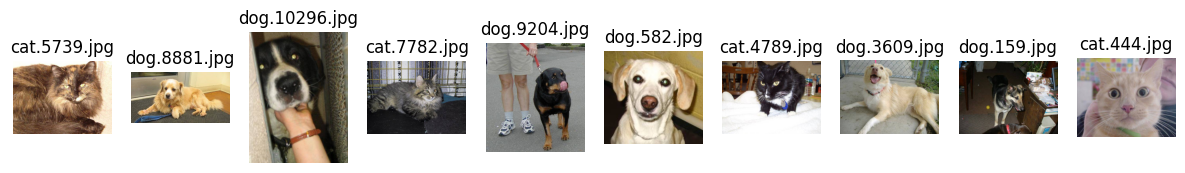

In [5]:
train_folder = '/content/dogs-vs-cats/train/train'
load_and_display_images(train_folder, num_images=10)

In [6]:
dataset_path = '/content/dogs-vs-cats/train'

In [7]:
batch_size = 32
img_height = 150
img_width = 150

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [8]:
img = load_img('/content/dogs-vs-cats/train/train/cat.0.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

In [9]:
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='/content/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break

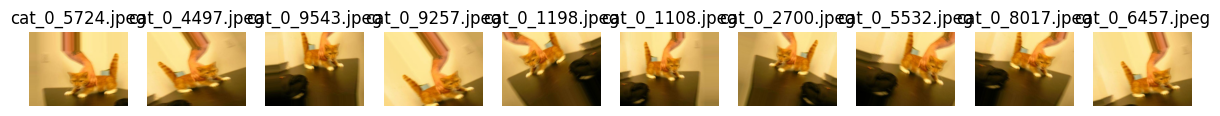

In [10]:
preview_folder = '/content/preview'
load_and_display_images(preview_folder, num_images=10)

In [11]:
# Buliding the CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


459/625 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.9945 - loss: 0.0101

In [ ]:
def evaluate_model(model, validation_generator):
    val_steps = validation_generator.samples // validation_generator.batch_size
    y_pred = model.predict(validation_generator, steps=val_steps)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = validation_generator.classes[:len(y_pred_classes)]

    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['cat', 'dog']))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model, validation_generator)
